In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path

from utils.data import load_xval
from utils.plotting import load_default_mpl_config, savefig

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/timeseries_vis/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.to_dataframe().reset_index()
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

In [2]:
xval_ds = load_xval('../../runs/basin_level/staticall_allbasins/LSTM/xval/').compute()
xval_ds = xval_ds.where((xval_ds.folds > 2), drop=True).compute()

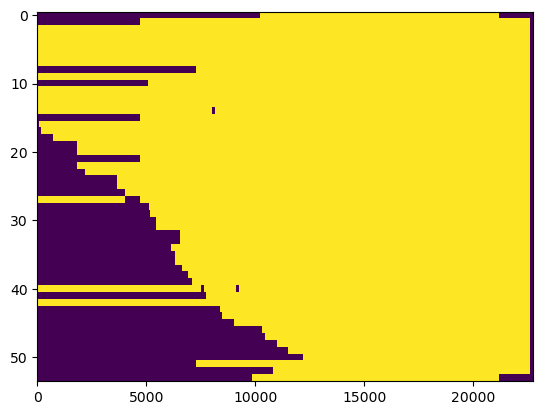

In [3]:
plt.imshow(xval_ds.Qmm.notnull(), aspect='auto', interpolation='none')

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


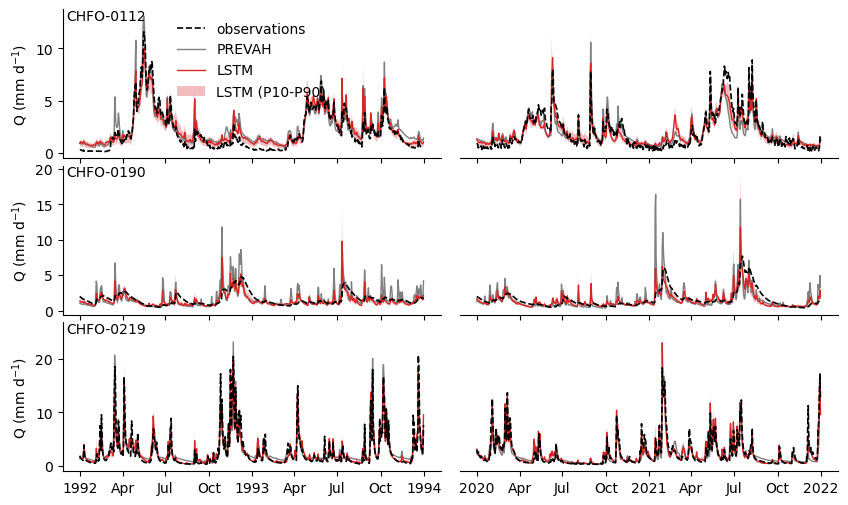

In [4]:
station_ids = [10, 30, 42]

fig, axes = plt.subplots(
    nrows=len(station_ids),
    ncols=2,
    figsize=(10, 2 * len(station_ids)),
    sharey='row',
    sharex='col',
    gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

time_subsets = [
    slice('1992', '1993'),
    slice('2020', '2021')
]

for s, station_id in enumerate(station_ids):
    for i, time_subset in enumerate(time_subsets):

        ax = axes[s, i]

        ds_sel = xval_ds.sel(time=time_subset).isel(station=station_id).compute()

        ax.plot(
            ds_sel.time,
            ds_sel.Qmm,
            color='k',
            lw=1.2,
            ls='--',
            zorder=10,
            label='observations'
        )
        ax.plot(
            ds_sel.time,
            ds_sel.Qmm_prevah,
            color='0.5',
            lw=1.0,
            # ls='--',
            label='PREVAH'
        )
        ax.plot(
            ds_sel.time,
            ds_sel.Qmm_mod.quantile(0.5, dim='cv'),
            color='tab:red',
            lw=1.0,
            label='LSTM'
        )
        ax.fill_between(
            ds_sel.time,
            ds_sel.Qmm_mod.quantile(0.10, dim='cv'),
            ds_sel.Qmm_mod.quantile(0.9, dim='cv'),
            edgecolor='none',
            facecolor='tab:red',
            alpha=0.3,
            label='LSTM (P10-P90)'
        )

        if i == 0:
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylabel('Q (mm d$^{-1}$)')
            ax.text(0.01, 1.0, ds_sel.station.item(), ha='left', va='top', transform=ax.transAxes)            

            if s == 0:
                ax.legend(frameon=False)
        else:
            ax.spines[['right', 'top', 'left']].set_visible(False)
            ax.tick_params('y', length=0, width=0, which='major')

        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

savefig(fig, path=PLOT_PATH / 'ts_plot.png')

In [8]:
import xarray as xr


def decode_time_string(x: list[str]) -> list[slice]:
    if not isinstance(x, list):
        raise TypeError(
            f'`x` must be `None` or a `list`, is `{type(x).__name__}`.'
        )

    if len(x) == 0:
        raise ValueError(
            '`x` must not be empty.'
        )

    time_slices = []
    for el in x:
        if not isinstance(el, str):
            raise ValueError(
                f'element \'{el}\' must be of type `str`, is `{type(el).__name__}`.'
            )

        if ',' not in el:
            raise ValueError(
                'each time item must be a comma separated pair of start time, end time, e.g., \'2001,2003-05-01\', '
                f'but no comma found in element \'{el}\'.'
            )

        if ' ' in el:
            raise ValueError(
                'each time item must be a comma separated pair of start time, end time, e.g., \'2001,2003-05-01\', '
                f'with no whitespaces, but whitespace found in element \'{el}\'.'
            )

        start_date, end_date = el.split(',')

        try:
            xr.cftime_range(start_date, end_date)

        except Exception as e:
            raise RuntimeError(
                f'Could not parse element \'{el}\' to time stamps. Infered time start was \'{start_date}\' and '
                f'time end was \'{end_date}\'.'
            )
        
        time_slices.append(slice(start_date, end_date))

    return time_slices


In [10]:
decode_time_string(['2001,2010-05-06'])

[slice('2001', '2010-05-06', None)]